In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [50]:
# Ignore deprecation warnings
import warnings
warnings.filterwarnings("ignore")

## Data Loading and Exploration

In [51]:
# Import libraries
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from PIL import Image
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [52]:
# Load and analyse dataset
netflix_overall = pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv")
netflix_overall.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [53]:
# Split dataset by types
netflix_shows = netflix_overall[netflix_overall['type'] == 'TV Show']
netflix_movies = netflix_overall[netflix_overall['type'] == 'Movie']

## Data Visualisations

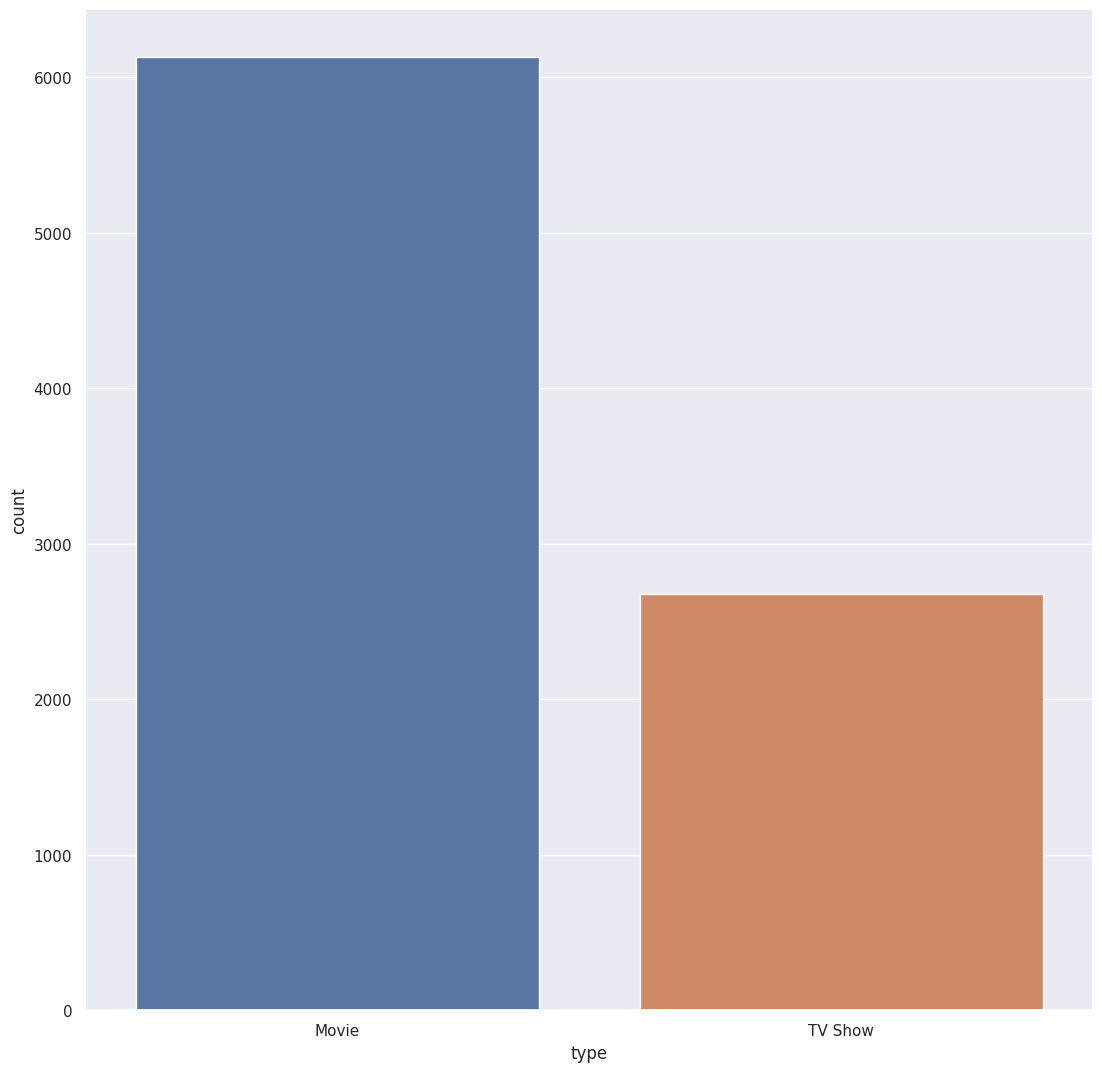

In [54]:
# Visualisation of count by type in dataset
ax = sns.countplot(x = "type", data = netflix_overall)

In [55]:
# Preparing dataframe for visualisations
netflix_date = netflix_overall[['date_added']].dropna()
netflix_date['year'] = netflix_date['date_added'].apply(lambda x : x.split(', ')[-1])
netflix_date['month'] = netflix_date['date_added'].apply(lambda x : x.lstrip().split(' ')[0])

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'][::-1]
df = netflix_date.groupby('year')['month'].value_counts().unstack().fillna(0)[month_order].T

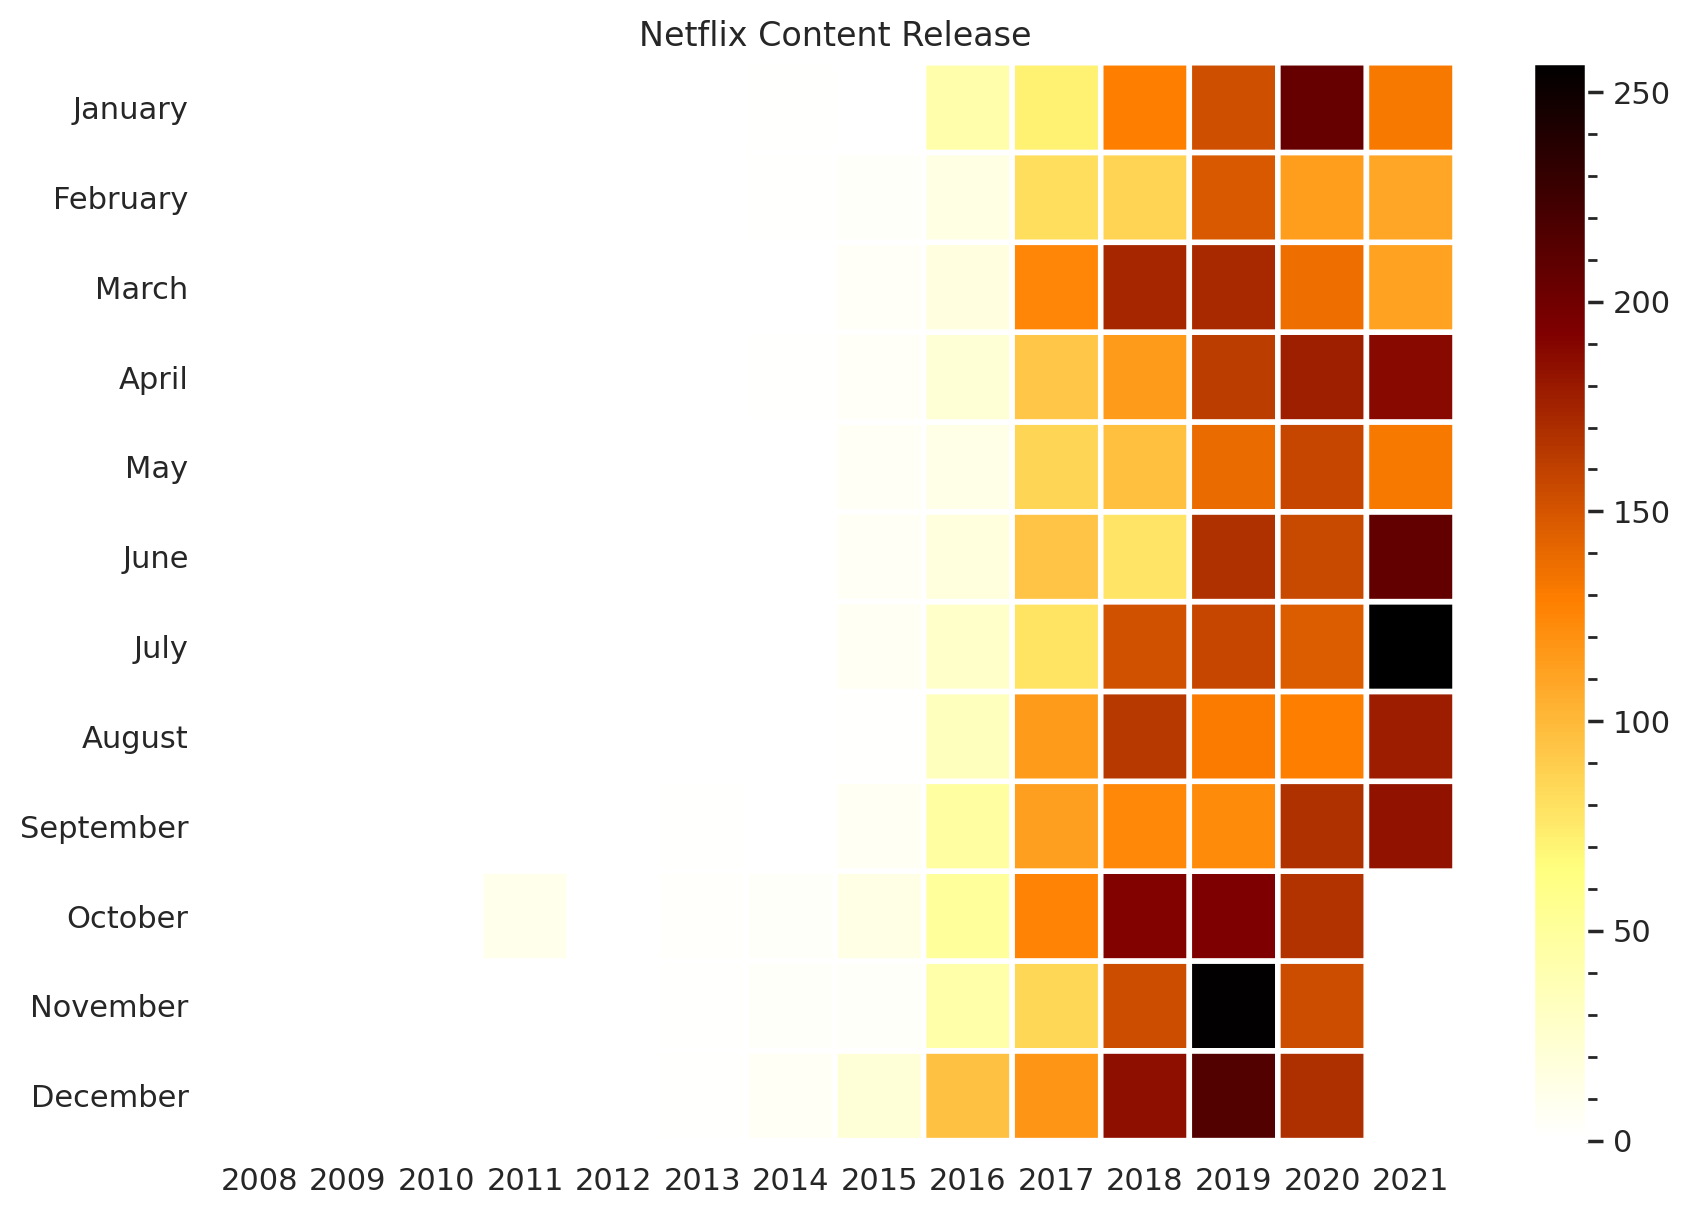

In [56]:
# Visualisation of content released month-wise as heatmap
plt.figure(figsize = (10, 7), dpi = 200)
plt.pcolor(df, cmap = 'afmhot_r', edgecolors = 'white', linewidths = 2)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)

plt.title('Netflix Content Release')

cbar = plt.colorbar()
cbar.ax.tick_params() 
cbar.ax.minorticks_on()

plt.show()

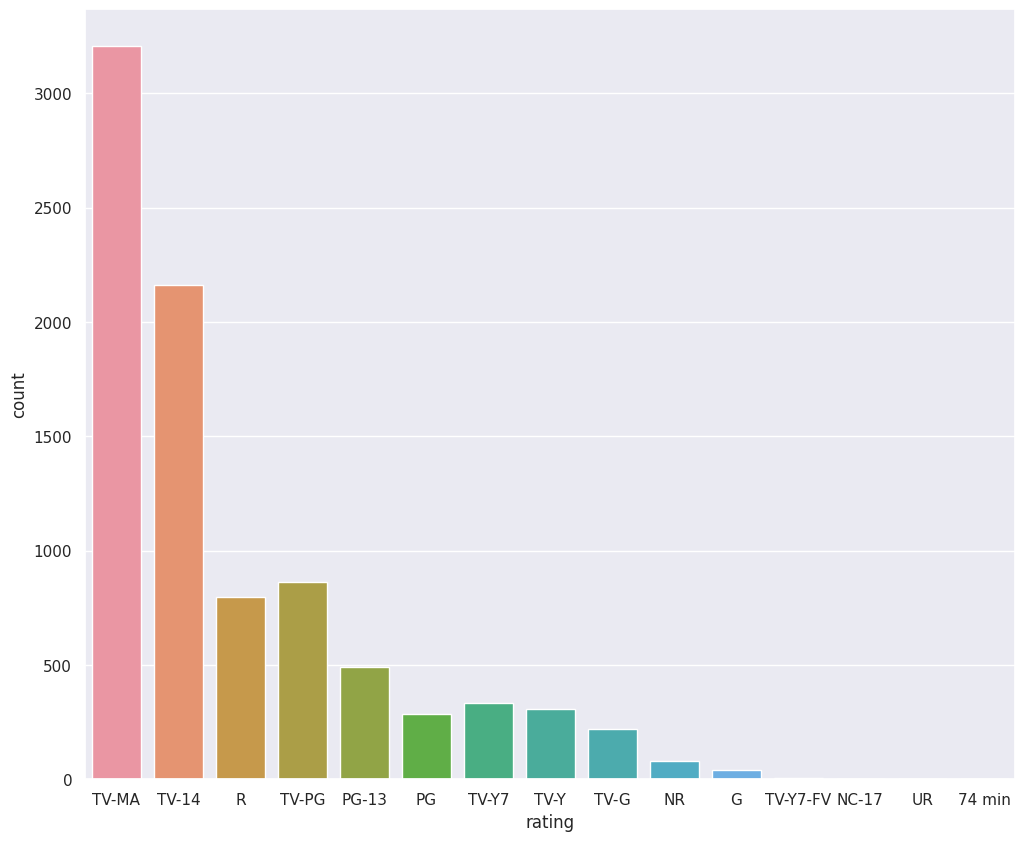

In [57]:
# Visualisation of ratings frequencies
plt.figure(figsize = (12,10))
ax = sns.countplot(x = "rating", data = netflix_overall,
                   order = netflix_movies['rating'].value_counts().index[0:15])

In [58]:
# Import IMDB ratings to cross-reference
imdb_ratings = pd.read_csv('/kaggle/input/imdbextensivedataset/IMDb ratings.csv',
                         usecols = ['weighted_average_vote'])
imdb_titles = pd.read_csv('/kaggle/input/imdbextensivedataset/IMDb movies.csv',
                        usecols = ['title', 'year', 'genre'])

In [59]:
# Create a dataframe to hold titles alongside ratings
ratings = pd.DataFrame({'Title': imdb_titles.title,
                        'Release Year': imdb_titles.year,
                        'Rating': imdb_ratings.weighted_average_vote,
                        'Genre': imdb_titles.genre})

ratings.drop_duplicates(subset = ['Title', 'Release Year', 'Rating'],
                        inplace = True)
ratings.dropna()
ratings.head()

,Title,Release Year,Rating,Genre
0,Miss Jerry,1894,5.9,Romance
1,The Story of the Kelly Gang,1906,6.1,"Biography, Crime, Drama"
2,Den sorte drøm,1911,5.8,Drama
3,Cleopatra,1912,5.2,"Drama, History"
4,L'Inferno,1911,7.0,"Adventure, Drama, Fantasy"


In [60]:
# Inner joining IMDB dataset with Netflix dataset to get titles common in both
joint_data = ratings.merge(netflix_overall, left_on = 'Title',
                         right_on = 'title', how = 'inner')
joint_data = joint_data.sort_values(by = 'Rating', ascending = False)

In [61]:
# Visualisation of popular content by IMDB ratings as sunburst chart
top_rated = joint_data[0: 10]
fig = px.sunburst(top_rated, path = ['title', 'country'],
                  values = 'Rating', color = 'Rating')
fig.show()

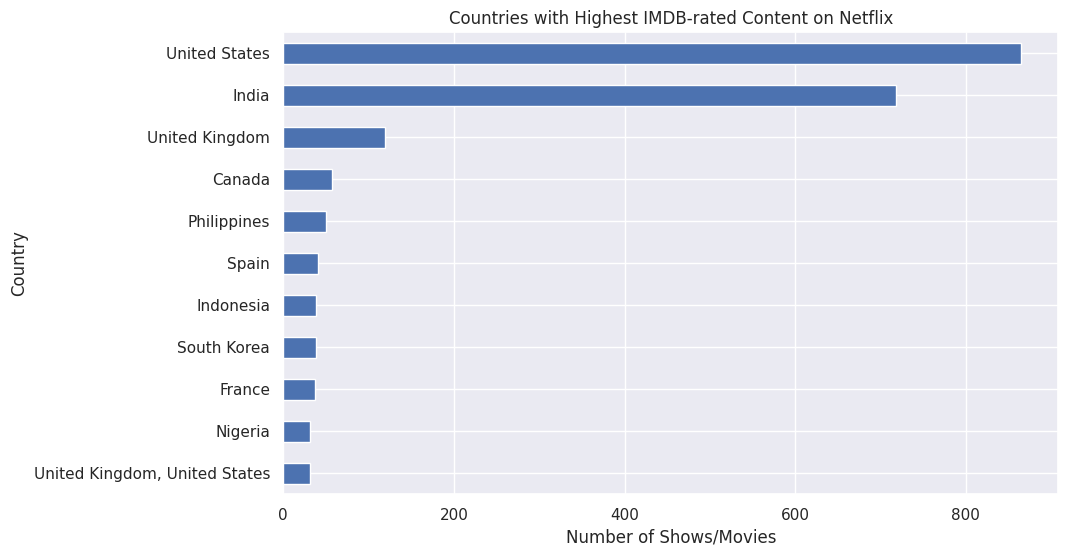

In [62]:
# Visualisation of countries with highest IMDB-rated content
country_count = joint_data['country'].value_counts().sort_values(ascending = False)
top_countries = country_count.head(11)

plt.figure(figsize = (10, 6))
top_countries.plot(kind = 'barh')
plt.xlabel('Number of Shows/Movies')
plt.ylabel('Country')
plt.title('Countries with Highest IMDB-rated Content on Netflix')
plt.gca().invert_yaxis()
plt.show()

In [63]:
# Process genres content is classified under
genres = list(netflix_overall['listed_in'])
gen = []

for i in genres:
    i = list(i.split(','))
    for j in i:
        gen.append(j.replace(' ', ""))
g=Counter(gen)

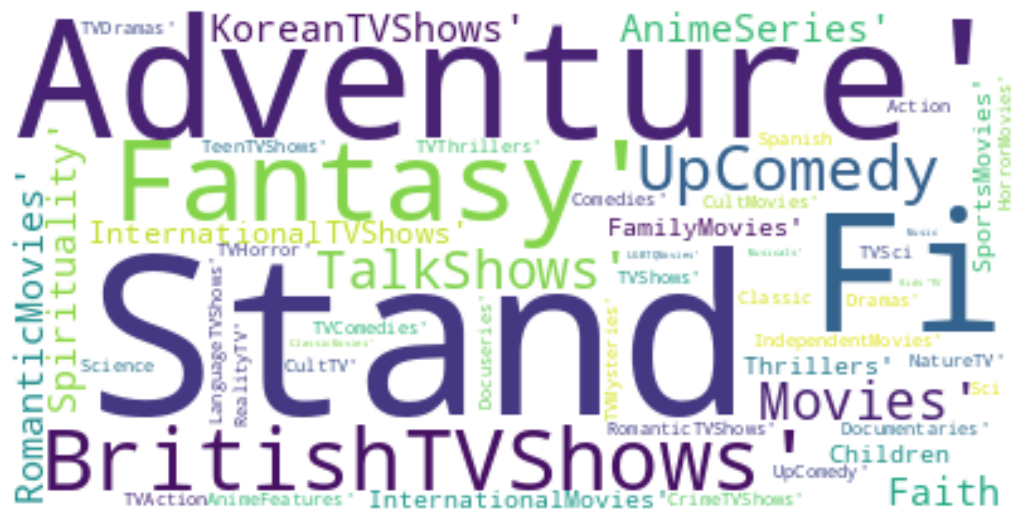

In [64]:
# Visualisation of top genres as wordcloud
text = list(set(gen))
plt.rcParams['figure.figsize'] = (13, 13)
wordcloud = WordCloud(background_color = "white").generate(str(text))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

## Recommendation System

### Basic Similarity Score-based Recommender

In [65]:
# Construct TF-IDF matrix by fitting and transforming data
tfidf = TfidfVectorizer(stop_words='english')
netflix_overall['description'] = netflix_overall['description'].fillna('')
tfidf_matrix = tfidf.fit_transform(netflix_overall['description'])
tfidf_matrix.shape

(8807, 18895)

In [66]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Create quick look up for index of a title
indices = pd.Series(netflix_overall.index,
                    index = netflix_overall['title']).drop_duplicates()

In [67]:
# Define function to similar movies based on similarity scores
def get_recommendations(title, cosine_sim = cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return netflix_overall['title'].iloc[movie_indices]

In [68]:
# Test the basic model
get_recommendations('Stranger Things')

4733               Rowdy Rathore
1240                  Safe Haven
1487             Sakho & Mangane
8198     The Autopsy of Jane Doe
2419               Big Stone Gap
6518            Come and Find Me
6760                   FirstBorn
8026             Sinister Circle
4201                 Hardy Bucks
1270    Sin senos sí hay paraíso
Name: title, dtype: object

### Content-based Filtered Recommender Based on Multiple Metrics

In [69]:
filledna = netflix_overall.fillna('')
filledna.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,,,,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [70]:
# Define simple data cleaning function
def clean_data(x):
        return str.lower(x.replace(" ", ""))

In [71]:
# Apply function to required features
features = ['title', 'director', 'cast', 'listed_in', 'description']
filledna = filledna[features]

for feature in features:
    filledna[feature] = filledna[feature].apply(clean_data)

filledna.head()

,title,director,cast,listed_in,description
0,dickjohnsonisdead,kirstenjohnson,,documentaries,"asherfathernearstheendofhislife,filmmakerkirst..."
1,blood&water,,"amaqamata,khosingema,gailmabalane,thabangmolab...","internationaltvshows,tvdramas,tvmysteries","aftercrossingpathsataparty,acapetownteensetsou..."
2,ganglands,julienleclercq,"samibouajila,tracygotoas,samueljouy,nabihaakka...","crimetvshows,internationaltvshows,tvaction&adv...","toprotecthisfamilyfromapowerfuldruglord,skille..."
3,jailbirdsneworleans,,,"docuseries,realitytv","feuds,flirtationsandtoilettalkgodownamongthein..."
4,kotafactory,,"mayurmore,jitendrakumar,ranjanraj,alamkhan,ahs...","internationaltvshows,romantictvshows,tvcomedies",inacityofcoachingcentersknowntotrainindia’sfin...


In [72]:
# Define simple soup function
def create_soup(x):
    return x['title']+ ' ' + x['director'] + ' ' + x['cast'] + ' ' +x['listed_in']+' '+ x['description']

In [73]:
# Apply function to required data
filledna['soup'] = filledna.apply(create_soup, axis = 1)

In [74]:
# Construct CountVectorizer matrix by fitting and transforming data
count = CountVectorizer(stop_words = 'english')
count_matrix = count.fit_transform(filledna['soup'])

In [75]:
# Compute the cosine similarity matrix
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

# Create quick look up for index of a title
filledna = filledna.reset_index()
indices = pd.Series(filledna.index, index = filledna['title'])

In [76]:
# Define function to similar movies based on similarity scores
def get_recommendations_updated(title, cosine_sim=cosine_sim):
    title=title.replace(' ','').lower()
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return netflix_overall['title'].iloc[movie_indices]

In [77]:
# Test the updated model
get_recommendations_updated('Stranger Things', cosine_sim2)

5200                 Beyond Stranger Things
2190                   The Umbrella Academy
6953                                  Helix
3187                            Nightflyers
241                                Manifest
3707                           Motown Magic
8421                         The Messengers
2303                            Warrior Nun
1473         Chilling Adventures of Sabrina
8541    The Twilight Zone (Original Series)
Name: title, dtype: object